# VAE (AutoencoderKL) 입출력 시각화

## VAE 구조
- Encoder: 이미지 → Latent Space
- Decoder: Latent Space → 이미지

## 입력/출력
- **입력**: 이미지 텐서 (B, 3, H, W), 범위 [-1, 1], H=W=224
- **인코딩 출력**: Latent 텐서 (B, 4, H/8, W/8) = (B, 4, 28, 28), 스케일링: 0.18215
- **디코딩 출력**: 복원된 이미지 텐서 (B, 3, H, W), 범위 [-1, 1]

## 1. Import 및 헬퍼 함수

In [16]:
import torch
import matplotlib.pyplot as plt
from diffusers.models import AutoencoderKL
from torchvision import transforms
from PIL import Image
import requests
from io import BytesIO
import numpy as np

%matplotlib inline

In [17]:
def load_image_from_url(url, image_size=224):
    """URL에서 이미지 로드 및 전처리"""
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGB')

    _transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])
    return _transform(img).unsqueeze(0), img


def tensor_to_image(tensor):
    """텐서를 이미지로 변환 ([-1, 1] -> [0, 255])"""
    img = (tensor * 0.5 + 0.5).clamp(0, 1)
    img = img.permute(0, 2, 3, 1).cpu().numpy()
    return (img * 255).astype(np.uint8)


def visualize_latent(latent, title="Latent Channels"):
    """Latent space 4채널 시각화 (2x2 grid)"""
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))
    fig.suptitle(title, fontsize=14)

    latent_np = latent[0].cpu().numpy()

    for i in range(4):
        row, col = i // 2, i % 2
        im = axes[row, col].imshow(latent_np[i], cmap='viridis')
        axes[row, col].set_title(f'Channel {i}\nmin={latent_np[i].min():.2f}, max={latent_np[i].max():.2f}')
        axes[row, col].axis('off')
        plt.colorbar(im, ax=axes[row, col], fraction=0.046)

    plt.tight_layout()
    return fig

## 2. VAE 모델 로드

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# VAE 로드
print("Loading VAE (stabilityai/sd-vae-ft-ema)...")
# vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema").to(device)
vae = AutoencoderKL.from_pretrained("logs/sd-vae-ft-ema").to(device)
vae.eval()
print("VAE loaded successfully!")

Using device: cuda
Loading VAE (stabilityai/sd-vae-ft-ema)...
VAE loaded successfully!


## 3. 샘플 이미지 로드

Loading image from: https://raw.githubusercontent.com/amirbar/amirbar.github.io/refs/heads/master/images/recon.png


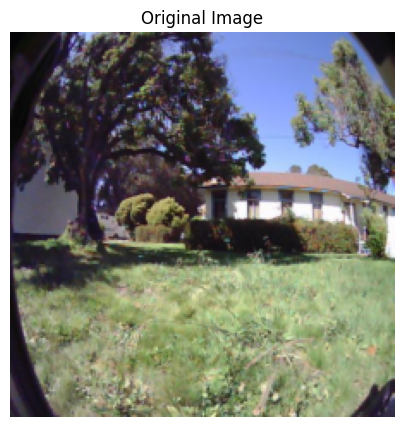

Image tensor shape: torch.Size([1, 3, 224, 224])


In [19]:
url = 'https://raw.githubusercontent.com/amirbar/amirbar.github.io/refs/heads/master/images/recon.png'
print(f"Loading image from: {url}")
x, original_pil = load_image_from_url(url)
x = x.to(device)

# 원본 이미지 표시
plt.figure(figsize=(5, 5))
plt.imshow(original_pil)
plt.title("Original Image")
plt.axis('off')
plt.show()

print(f"Image tensor shape: {x.shape}")

## 4. VAE 인코딩 (Encoding)

In [20]:
print("="*60)
print("VAE ENCODING")
print("="*60)

print(f"\nInput shape: {x.shape}")
print(f"Input dtype: {x.dtype}")
print(f"Input range: [{x.min().item():.3f}, {x.max().item():.3f}]")

with torch.no_grad():
    # encode()는 DiagonalGaussianDistribution 반환
    encoder_output = vae.encode(x)
    print(f"\nEncoder output type: {type(encoder_output)}")
    print(f"Encoder output (latent_dist) type: {type(encoder_output.latent_dist)}")

    # latent_dist에서 샘플링
    latent = encoder_output.latent_dist.sample()
    print(f"\nLatent shape (before scaling): {latent.shape}")
    print(f"Latent range (before scaling): [{latent.min().item():.3f}, {latent.max().item():.3f}]")

    # 스케일링 적용 (학습/추론시 사용되는 값)
    latent_scaled = latent * 0.18215
    print(f"\nLatent shape (after scaling × 0.18215): {latent_scaled.shape}")
    print(f"Latent range (after scaling): [{latent_scaled.min().item():.3f}, {latent_scaled.max().item():.3f}]")

VAE ENCODING

Input shape: torch.Size([1, 3, 224, 224])
Input dtype: torch.float32
Input range: [-0.976, 1.000]

Encoder output type: <class 'diffusers.models.modeling_outputs.AutoencoderKLOutput'>
Encoder output (latent_dist) type: <class 'diffusers.models.autoencoders.vae.DiagonalGaussianDistribution'>

Latent shape (before scaling): torch.Size([1, 4, 28, 28])
Latent range (before scaling): [-14.808, 23.917]

Latent shape (after scaling × 0.18215): torch.Size([1, 4, 28, 28])
Latent range (after scaling): [-2.697, 4.356]


## 5. Latent Space 시각화

Saved: vae_latent_channels.png


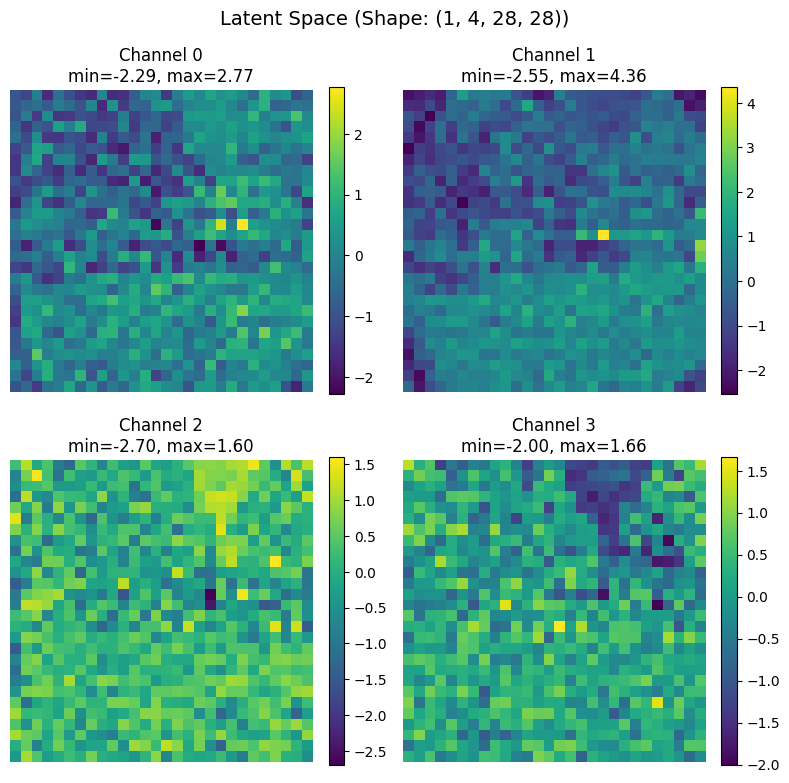

In [21]:
visualize_latent(latent_scaled, f"Latent Space (Shape: {tuple(latent_scaled.shape)})")
plt.savefig('vae_latent_channels.png', dpi=150, bbox_inches='tight')
print("Saved: vae_latent_channels.png")
plt.show()

## 6. VAE 디코딩 (Decoding)

In [10]:
print("="*60)
print("VAE DECODING")
print("="*60)

with torch.no_grad():
    # 디코딩 시 스케일링 역변환
    latent_for_decode = latent_scaled / 0.18215
    decoded = vae.decode(latent_for_decode).sample

    print(f"\nOutput shape: {decoded.shape}")
    print(f"Output dtype: {decoded.dtype}")
    print(f"Output range: [{decoded.min().item():.3f}, {decoded.max().item():.3f}]")

VAE DECODING

Output shape: torch.Size([1, 3, 224, 224])
Output dtype: torch.float32
Output range: [-0.979, 1.077]


## 7. 원본 vs 복원 이미지 비교

Saved: vae_encode_decode.png


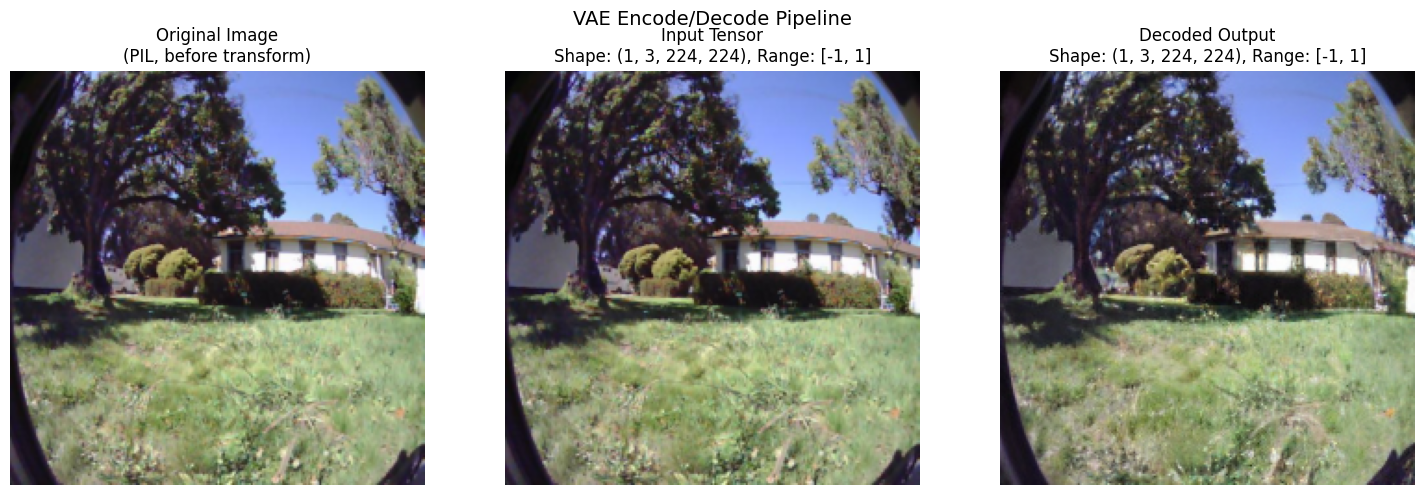

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("VAE Encode/Decode Pipeline", fontsize=14)

# 원본 이미지
axes[0].imshow(original_pil)
axes[0].set_title(f"Original Image\n(PIL, before transform)")
axes[0].axis('off')

# 입력 텐서 시각화
input_img = tensor_to_image(x)[0]
axes[1].imshow(input_img)
axes[1].set_title(f"Input Tensor\nShape: {tuple(x.shape)}, Range: [-1, 1]")
axes[1].axis('off')

# 복원된 이미지
output_img = tensor_to_image(decoded)[0]
axes[2].imshow(output_img)
axes[2].set_title(f"Decoded Output\nShape: {tuple(decoded.shape)}, Range: [-1, 1]")
axes[2].axis('off')

plt.tight_layout()
plt.savefig('vae_encode_decode.png', dpi=150, bbox_inches='tight')
print("Saved: vae_encode_decode.png")
plt.show()

## 8. VAE 요약

Saved: vae_summary.png


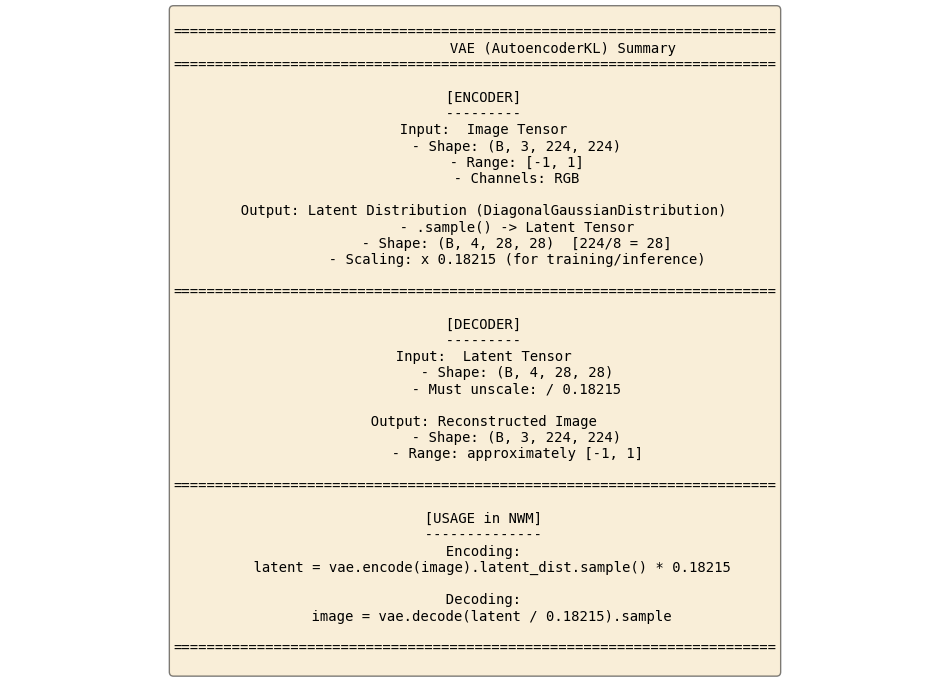


Done!


In [12]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.axis('off')

summary_text = """
========================================================================
                     VAE (AutoencoderKL) Summary
========================================================================

  [ENCODER]
  ---------
  Input:  Image Tensor
          - Shape: (B, 3, 224, 224)
          - Range: [-1, 1]
          - Channels: RGB

  Output: Latent Distribution (DiagonalGaussianDistribution)
          - .sample() -> Latent Tensor
          - Shape: (B, 4, 28, 28)  [224/8 = 28]
          - Scaling: x 0.18215 (for training/inference)

========================================================================

  [DECODER]
  ---------
  Input:  Latent Tensor
          - Shape: (B, 4, 28, 28)
          - Must unscale: / 0.18215

  Output: Reconstructed Image
          - Shape: (B, 3, 224, 224)
          - Range: approximately [-1, 1]

========================================================================

  [USAGE in NWM]
  --------------
  Encoding:
    latent = vae.encode(image).latent_dist.sample() * 0.18215

  Decoding:
    image = vae.decode(latent / 0.18215).sample

========================================================================
"""

ax.text(0.5, 0.5, summary_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='center', horizontalalignment='center',
        fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.savefig('vae_summary.png', dpi=150, bbox_inches='tight')
print("Saved: vae_summary.png")
plt.show()

print("\n" + "="*60)
print("Done!")
print("="*60)